In [1]:
import time
import numpy as np
from matplotlib import pyplot
from matplotlib import pyplot as plt
import pickle
import pandas as pd
import IPython.display as display

In [2]:
data_list=['Barclays-Noida-3.2-Jan', 'Barclays-Noida-3.2-Feb', 'Barclays-Noida-3.2-March','Barclays-Noida-3.2-April']

for month in range(len(data_list)):
    month_data=pickle.load(open('../../processed_data/'+data_list[month]+'.p', "rb" ))
    if month==0:
        data=month_data.copy()
    else:
        data=pd.concat([data,month_data])
data=data.drop(['Country','Department','Resource Type'],axis=1)

In [3]:
data=data.groupby([data.floor,data.seatName,pd.Grouper(key='Datetime',freq='H')])
data=data['Space'].agg([np.sum])
data.reset_index(inplace=True)
data['isOccupied']=[0 if x <3 else 1 for x in data['sum']]
data=data.drop(['sum'],axis=1)
floor_data=data.groupby([data.floor,pd.Grouper(key='Datetime',freq='D')])['isOccupied'].agg([np.sum])
floor_data.reset_index(inplace=True)
one_floor=floor_data.loc[floor_data.floor=='Level 9']
one_floor.set_index('Datetime',inplace=True)
one_floor.index.freq='D'
one_floor.head(3)

,floor,sum
Datetime,,
2018-01-29,Level 9,2307
2018-01-30,Level 9,242
2018-01-31,Level 9,1610


In [5]:
from sklearn.metrics import log_loss,mean_squared_log_error,r2_score,mean_squared_error
from math import sqrt

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def metric_scores(y_true, y_pred):
    mse=mean_squared_error(y_true,y_pred)
    #msle=mean_squared_log_error(y_true,y_pred)
    rmse = sqrt(mean_squared_error(y_true,y_pred))
    r2=r2_score(y_true,y_pred)
    mape=mean_absolute_percentage_error(y_true,y_pred)
    #print('msle',msle)
    print('rmse',rmse)
    print('mse',mse)
    print('mape',mape)
    print('r2',r2)
def plot_data(y_hat):
    
    #plt.figure(figsize=(12,8))
    #plt.plot(train['Space'], label='Train')
    plt.plot(y_hat['sum'], label='Test')
    plt.plot(y_hat['avg_forecast'], label='Average Forecast')
    plt.legend(loc='best')
    plt.show()

In [7]:
date_split='2018-04-24'
train,test=one_floor.loc[one_floor.index<date_split],one_floor.loc[one_floor.index>=date_split]

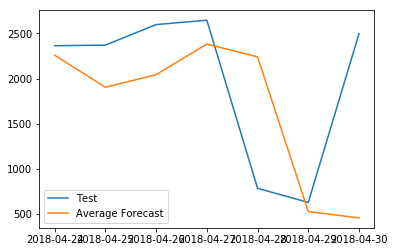

rmse 995.4867267388944
mse 990993.8231133183
mape 48.66344837994704
r2 -0.48502350114424475


In [13]:
y_hat_avg=test.copy()
pred_list=[]

#daterange = pd.date_range('1', '31',freq='M')

for i in range(7):
        day_floor_data= train.loc[train.index.weekday==i]
        pred_list.append(day_floor_data['sum'].mean())
        
y_hat_avg['avg_forecast'] =pred_list
plot_data(y_hat_avg)
metric_scores(y_hat_avg['sum'],y_hat_avg['avg_forecast'])

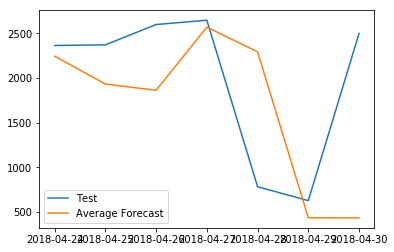

rmse 1025.0483438076749
mse 1050724.107142857
mape 51.69827870754321
r2 -0.5745304924544652


In [19]:
y_hat_avg=test.copy()
pred_list=[]
for i in range(7):
        day_floor_data= train.loc[train.index.weekday==i]
        pred_list.append(day_floor_data['sum'].rolling(6).mean().iloc[-1])

y_hat_avg['avg_forecast'] =pred_list
plot_data(y_hat_avg)
metric_scores(y_hat_avg['sum'],y_hat_avg['avg_forecast'])

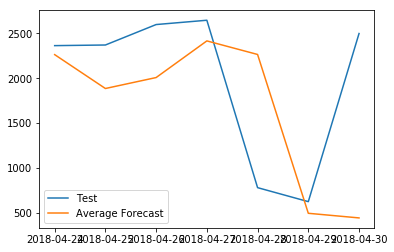

rmse 1006.6041053461988
mse 1013251.8248998214
mape [49.89058114]
r2 -0.5183775493436835


In [23]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
y_hat_avg=test.copy()
pred_list=[]
for i in range(7):
        day_floor_data= train.loc[train.index.weekday==i]
        fit2 = SimpleExpSmoothing(np.asarray(day_floor_data['sum'])).fit(smoothing_level=0.1,optimized=True)
        pred_list.append(fit2.forecast(1))

y_hat_avg['avg_forecast'] =pred_list
plot_data(y_hat_avg)
metric_scores(y_hat_avg['sum'],y_hat_avg['avg_forecast'])

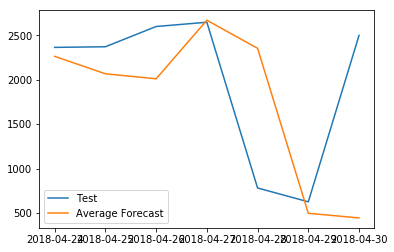

rmse 1011.5984289567563
mse 1023331.3814677774
mape [49.26778]
r2 -0.5334819607289156


In [24]:
from statsmodels.tsa.api import  Holt
y_hat_avg=test.copy()
pred_list=[]
for i in range(7):
        day_floor_data= train.loc[train.index.weekday==i]
        fit1 = Holt(np.asarray(day_floor_data['sum']),damped=True).fit(smoothing_level = 0.1,damping_slope=0.9,
                                                            smoothing_slope = 0.01,optimized=True)
        pred_list.append(fit1.forecast(1))
        

y_hat_avg['avg_forecast'] =pred_list
plot_data(y_hat_avg)
metric_scores(y_hat_avg['sum'],y_hat_avg['avg_forecast'])